## __Predicción de eclipses mediante el uso de Machine Learning__

Durante toda nuestra vida, y desde los inicios mismos de nuestra historia, convivimos con este interesante y notorio fenómeno que, durante mucho tiempo, dio lugar a curiosas e interesantes historias que intentaban explicar su funcionamiento. Hoy, entendemos plenamente su funcionamiento, y, a forma de corolario de la comprensión de la mecánica celeste, somos capaces de predecirlo de forma precisa para nuestro ocio o para usarlo en investigación científica, como se hizo en 1919 para someter a prueba por primera vez la Relatividad General de Einstein.

A pesar de la fuerte comprensión teórica que se tiene actualmente sobre ese y otros fenómenos de la mecánica celeste, resulta difícil a nivel de cálculos y poder de cómputo, desarrollar algoritmos eficientes basados en nuestras teorías que sean capaces de, al mismo tiempo, obtener predicciones precisas y obtener resultados en tiempos de cómputo racionales. Por otro lado, con el actual desarrollo en el campo de la computación y el Aprendizaje Automático (Inteligencia Artificial), se ha notado que, bajo este paradigma, es posible entrenar modelos de aprendizaje que replican de forma correcta, y en tiempos de cálculo mucho más razonables, teorías y leyes físicas de nuestro universo, resultando en modelos de gran interés cuando se quiere replicar la realidad física de forma rápida (como se requiere por ejemplo en el campo de gráficos por computadora). 

Es así, como M. Sferdian, M. Frincu (2021) (https://irep.ntu.ac.uk/id/eprint/44130/), muestran la mejora computacional obtenida entre el métodos clásico implementado en un algoritmo de fuerza bruta, y el entrenamiento de un modelo de Machine Learning para la predicción de eclipses. En el trabajo actual, se replica el trabajo hecho en el artículo para entrenar el modelo de aprendizaje automático.

<!-- ### __Eclipses: La física__
Decimos que el sistema Sol (S) - Tierra (T) - Luna (L) se encuentra en eclipse si cualquiera de los dos cuerpos Tierra, o Luna, se encuentran en una posición en la que uno bloquea, al menos parcialmente, la luz proveniente del sol hacia el otro objeto. Dependiendo de la configuración en la que se encuentre el sistema, hablaremos de un eclipse lunar (S-T-L) o de un eclipse solar (S-L-T).

Para describir el proceso de formación de este fenómeno, debemos estudiar inicialmente las condiciones en las que se da el mismo; y dado que el sistema Tierra - Luna orbita en un plano tridimensional distinto al plano orbital (plano eclíptico) del sistema Sol - Tierra, definiremos distintos periodos de oscilación en distintos casos.

#### __Mes Sideral__
Definimos inicialmente el periodo de oscilación más intuitivo: el mes sideral. Este se define como el tiempo que le toma a la luna dar una vuelta alrededor de la tierra antes de volver al mismo punto medido respecto al fondo estelar. De forma más rigurosa, esto es, si definimos un punto fijo con coordenadas $(r,\theta,\phi)$ respecto a la tierra con un plano de referencia fijo respecto a su rotación, pero trasladándose con ella, el tiempo que le toma a la luna completar una vuelta alrededor de la tierra antes de regresar a ese mismo punto. Este mes tiene una duración aproximada de $27.321661$ días terrestres.

#### __Mes Sinódico__
Esta definición, aunque menos intuitiva, es la más razonable dadas las observaciones que podemos hacer desde la tierra. Este mes se define como el tiempo que le toma a la luna para completar una vuelta empezando y terminando en el plano normal a la eclíptica (el plano orbital de la tierra respecto al sol) que une los centros del sol y la tierra. Dado que la tierra se está moviendo en órbita elíptica alrededor del sol mientras que, a su vez, la luna orbita a la tierra, la orientación de este plano cambia (sin dejar de ser normal a la eclíptica) conforme la tierra se desplza; esto se traduce en que la luna no tiene que llegar al mismo punto del que partió, respecto a la tierra, sino que tiene que recorrer una mayor distancia, dada por el desplazamiento de este plano debido a la traslación terreste.

Este plano es el que define las fases lunares, dado que cuando la luna empieza, digamos, en su fase de luna nueva (mostrando su cara oscura a la tierra), está justo sobre este plano, y orbita la tierra, pasando por la fase de luna llena (también sobre el plano, pero en el lado opuesto de la tierra) hasta llegar nuevamente a la misma posición sobre el plano frente a la tierra respecto al sol, completando así el ciclo lunar. Este mes tiene una duración aproximada de $29.530588853$ días terrestres.

#### __Mes Dracónico__
Si la luna pasa todos los meses por posiciones delante y detrás de la tierra respecto al sol, ¿por qué no tenemos dos eclipses (uno solar y uno lunar) cada mes? Es porque el plano orbital de la luna está inclinado aproximadamente $5.14^\circ$ respecto al plano de la eclíptica, y este, anque precesa, lo hace de forma muy lenta, completando una vuelta cada aproximadamente 8 años terrestres. Por esto, la órbita lunar corta dos veces, en dos puntos (puntos nodales), con el plano de la eclíptica en cada órbita alrededor de la tierra, pero estos cortes no caen siempre en el plano definido para el mes sinódico, que es cuando la luna tiene la posibilidad de bloquear la luz que va del sol hacia la tierra, o viceversa.

El mes dracónico se define entonces como el tiempo que le toma a la luna completar una órbita alrededor de la tierra partiendo en un punto nodal y llegando a este mismo. Dado el movimiento de precesión del plano orbital de la luna al rededor de la tierra, este mes no coincide exactamente con el mes sideral, sino que difiere ligeramente, teniendo una duración aproximada de $27.212220817$ días terrestres.

#### __Mes Anomalístico__
Dado que el plano en el que orbita la luna a la tierra, está a su vez también está rotando, el tiempo que le toma a la luna dar una vuelta desde un ápsis (puntos de mayor o menor aproximación a la tierra) hasta este mismo punto, es ligeralemte mayor al mes sideral. Este tiempo que le toma a la luna empezar en un ápsis y orbitar la tierra hasta llegar el mismo, se denomina el mes anomalístico, y tiene una duración de aproximadamente $27.55454988$ días terrestres.

De lo anterior, decimos entonces que un eclipse pupede pasar cuando la posición de la luna coincide con algún punto nodal (mes dracónico), y este está a su vez cerca al plano normal a la eclíptica que une la tierra y el sol (mes sinódico). Estos planos, dado el movimiento de rotación del plano orbital de la luna respecto a la tierra, no coinciden siempre, por lo que a su vez, la ocurrencia del evento anterior está condicionada por los periodoos d  el mes anomalístico. -->

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
from include.aux_funcs import get_minimum_separation, get_minimum_separation_lunar
# from ML.confusion_matrix_helper import make_confusion_matrix
import warnings
warnings.filterwarnings("ignore")

def plot_cf_matrix(test_labels, predictions, label = ''):
    cf_matrix = confusion_matrix(test_labels, predictions)
    cf_matrix_norm = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(6, 5))
    sns.heatmap(cf_matrix_norm, annot=True, fmt='.2f', cmap='Reds',
                xticklabels=['No Eclipse', 'Eclipse'],
                yticklabels=['No Eclipse', 'Eclipse'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix (' + label + ')')
    plt.show()

# Data retrieval
df = pd.read_csv('data/solar-eclipses-classif.csv')
df['Is Eclipse'] = df['Is Eclipse'].replace({True: 1, False: 0}) # labels are treated as type int64
# check = df[df['Date'] == '2023-10-14'] # %Y-%M-%D date formatting
# print(check)

bias_pos = df[df['Date'] == '2019-12-31'].index.item() + 1 # sets the position of the given Date as bias for the training set
train, test = df[:bias_pos], df[bias_pos:]
train_labels, test_labels = np.array(train.pop('Is Eclipse')), np.array(test.pop('Is Eclipse'))
train.set_index('Date', inplace=True)
test.set_index('Date', inplace=True)
train, test = train.select_dtypes('number'), test.select_dtypes('number')
# test

### __K-Nearest Neighbors__

Model Accuracy: 0.9991887780970086
Model Score: 0.9991887780970086
Precision: 0.895
Recall: 0.9835164835164835
F1 Score: 0.9371727748691099


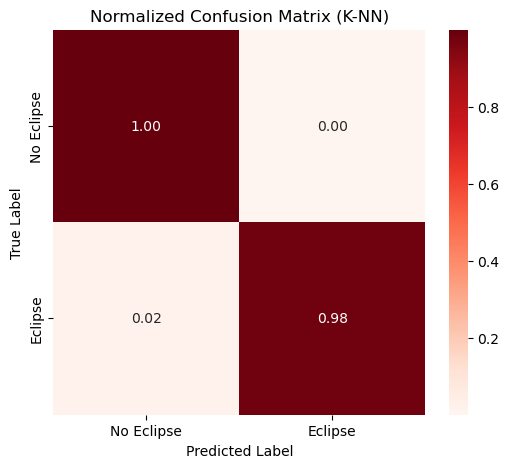

In [2]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(algorithm = 'auto',
    leaf_size = 30,
    metric = 'minkowski',
    n_neighbors = 7,
    p = 2,
    weights = 'uniform'
)
knn_model.fit(train, train_labels)

# metrics
# print(f'Model Accuracy: {knn_model.score(train, train_labels)}')
predictions = knn_model.predict(test)
print(f'Model Accuracy: {knn_model.score(test, test_labels)}')
print(f'Model Score: {knn_model.score(test, test_labels)}')
print(f'Precision: {precision_score(test_labels, predictions)}')
print(f'Recall: {recall_score(test_labels, predictions)}')
print(f'F1 Score: {f1_score(test_labels, predictions)}')
plot_cf_matrix(test_labels, predictions, label = 'K-NN')

In [3]:
date = '2023-10-14' # solar
# date = '2023-10-28' # lunar
# date = '2023-05-05' # lunar
# date = '2025-03-29' #solar
print(knn_model.predict([[get_minimum_separation(date)]])) # this function works only when predicting solar eclipses
# print(knn_model.predict([[get_minimum_separation_lunar(date)]])) # this function works only when predicting lunar eclipses

[1]


### __Logistic Regression__

Model Accuracy: 0.9991004028630657
Model Score: 0.9989183707960115
Precision: 0.8947368421052632
Recall: 0.9340659340659341
F1 Score: 0.913978494623656


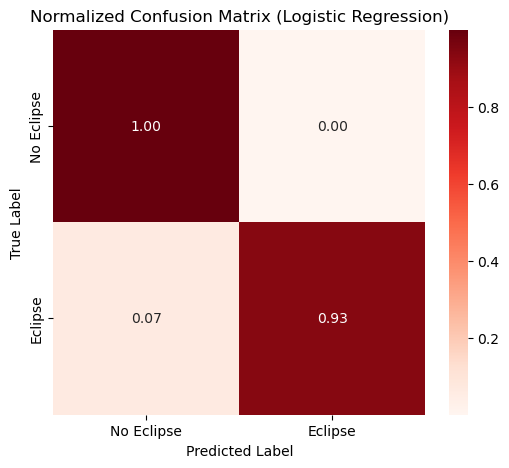

In [4]:
from sklearn.linear_model import LogisticRegression
logreg_model = LogisticRegression()
logreg_model.fit(train, train_labels)

# metrics
print(f'Model Accuracy: {logreg_model.score(train, train_labels)}')
predictions = logreg_model.predict(test)
# print(f'Model Accuracy: {logreg_model.score(train, train_labels)}')
print(f'Model Score: {logreg_model.score(test, test_labels)}')
print(f'Precision: {precision_score(test_labels, predictions)}')
print(f'Recall: {recall_score(test_labels, predictions)}')
print(f'F1 Score: {f1_score(test_labels, predictions)}')
plot_cf_matrix(test_labels, predictions, label = 'Logistic Regression')

### __Random Forest Classifier__

Model Accuracy: 0.9991887780970086
Model Score: 0.9991887780970086
Precision: 0.895
Recall: 0.9835164835164835
F1 Score: 0.9371727748691099


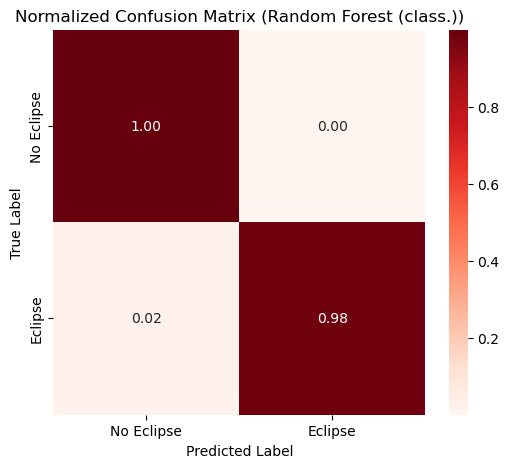

In [6]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100, 
    criterion='gini', 
    max_depth=2, # no overfitting
    min_samples_split=30, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_features=None, 
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    bootstrap=True, 
    oob_score=False, 
    n_jobs=None, 
    random_state=None, 
    verbose=0, 
    warm_start=False, 
    class_weight=None, 
    ccp_alpha=0.0, 
    max_samples=None
)
rf_model.fit(train, train_labels)
print(f'Model Accuracy: {rf_model.score(test, test_labels)}')
predictions = rf_model.predict(test)
# print(f'Model Accuracy: {rf_model.score(train, train_labels)}')
print(f'Model Score: {rf_model.score(test, test_labels)}')
print(f'Precision: {precision_score(test_labels, predictions)}')
print(f'Recall: {recall_score(test_labels, predictions)}')
print(f'F1 Score: {f1_score(test_labels, predictions)}')
plot_cf_matrix(test_labels, predictions, label = 'Random Forest (class.)')

### __Multi-layer Perceptron Classifier__

Model Accuracy: 0.9990873753591347
Model Score: 0.9990873753591347
Precision: 0.8974358974358975
Recall: 0.9615384615384616
F1 Score: 0.9283819628647215


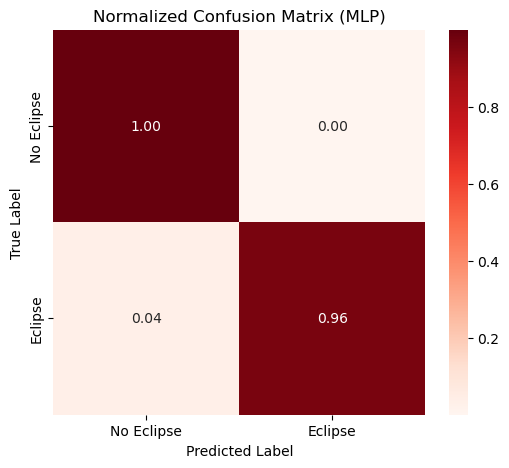

In [52]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(
    hidden_layer_sizes=(5,8,8), 
    activation='relu', 
    solver='adam', 
    max_iter=500)
mlp_model.fit(train,train_labels)
print(f'Model Accuracy: {mlp_model.score(test, test_labels)}')
predictions = mlp_model.predict(test)
# print(f'Model Accuracy: {rf_model.score(train, train_labels)}')
print(f'Model Score: {mlp_model.score(test, test_labels)}')
print(f'Precision: {precision_score(test_labels, predictions)}')
print(f'Recall: {recall_score(test_labels, predictions)}')
print(f'F1 Score: {f1_score(test_labels, predictions)}')
plot_cf_matrix(test_labels, predictions, label = 'MLP')